# Prepare indy

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from pkg.utils import *
import rospy
gtimer = GlobalTimer.instance()
rospy.init_node('indy_test', anonymous=True)

In [2]:
from pkg.indy_repeater import *

In [3]:
indy_ip = "192.168.0.63"  # Robot (Indy) IP
indy_name = "NRMK-Indy7"  # Robot name (Indy7)
indy = indytraj_client(server_ip=indy_ip, robot_name=indy_name)

In [4]:
with indy:
    indy.set_collision_level(5)
    indy.set_joint_vel_level(3)
    indy.set_task_vel_level(3)
    indy.set_joint_blend_radius(20)
    indy.set_task_blend_radius(0.2)
    indy.stop_motion()

    print(indy.get_collision_level())
    print(indy.get_joint_vel_level())
    print(indy.get_task_vel_level())
    print(indy.get_joint_blend_radius())
    print(indy.get_task_blend_radius())
    print(indy.get_joint_pos())

Connect: Server IP (192.168.0.63)
5
3
3
20.0
0.2
[-0.0069005036157029345, -0.013347026730372781, -90.02124628745429, 0.025779799659655166, -89.977157139548, 0.00010877552599010618]


## Test basic connection delay

In [5]:
# Conty 연결 안된 경우 4초 주기로 0.5초 가량의 전반적 통신 딜레이 발생함

Connect: Server IP (192.168.0.63)
sleep: 	149.0 ms/1000 = 0.149 ms (0.032/0.483)
get_robot_status: 	10149.0 ms/1000 = 10.149 ms (9.578/44.119)



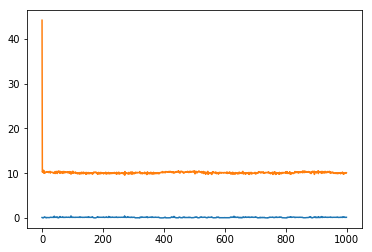

In [22]:
gtimer.reset()
indy.connect()
for _ in range(1000):
    gtimer.tic("sleep")
    indy.rate_x4.sleep()
    gtimer.toc("sleep", stack=True)
    gtimer.tic("get_robot_status")
    indy.get_robot_status()
    gtimer.toc("get_robot_status", stack=True)
indy.disconnect()
ax = plt.plot(gtimer.timelist_dict['sleep'])
ax = plt.plot(gtimer.timelist_dict['get_robot_status'])
print(gtimer)

# Test indy tracking

[ 0. -0. -0.  0. -0.  0.]
[ 0. -0. -0.  0. -0.  0.]
[0. 0. 0. 0. 0. 0.]


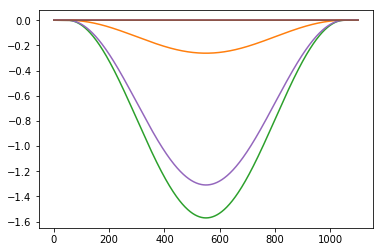

In [10]:
# Prepare path

N_t = 1000
MAG = 1#0~1
e_POS = np.deg2rad([[0, -15, -90, 0, -75, 0]])*np.transpose([MAG*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS = np.pad(e_POS, [[50,50],[0,0]],'edge')
plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [20]:
gtimer.reset()
# test init stop
indy.joint_move_make_sure(e_POS[0], N_repeat=5, connect=True)
indy.start_online_tracking(e_POS[0])

time.sleep(0.5)

qcount = 0
qcount_indy_list = []
looptime_list = []
networktime_list = []

i_q = 0
try:
    while i_q <len(e_POS):
        Q = e_POS[i_q]
        gtimer.tic("loop")
        Q_indy = Q#[0]*6
        i_q += indy.move_possible_joints_x4(Q_indy)
        qcount = indy.qcount
        qcount_indy_list.append(indy.qcount)
        looptime_list.append(gtimer.toc("loop"))
except Exception as e:
    print(e)
finally:
    indy.finish_online_tracking()

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


loop: 	21851.0 ms/4390 = 4.977 ms (1.12/10.825)



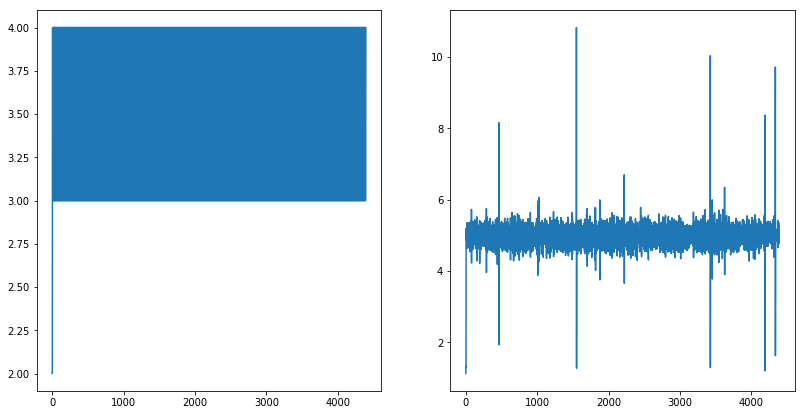

In [21]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_indy_list[1:])
plt.subplot(1,3,2)
ax = plt.plot(looptime_list[1:])
print(gtimer)

In [15]:
Q0_indy = np.deg2rad(indy.connect_and(indy.get_joint_pos))
indy.init_online_tracking(Q0_indy)
indy.move_joint_interpolated(qtar=Q0_indy+np.deg2rad(5), q0=Q0_indy, N_div=200)
indy.stop_online_tracking()
Q0_indy = np.deg2rad(indy.connect_and(indy.get_joint_pos))
indy.init_online_tracking(Q0_indy)
indy.move_joint_interpolated(qtar=Q0_indy+np.deg2rad(-5), q0=Q0_indy, N_div=200)
indy.stop_online_tracking()

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


In [18]:
indy.reset_robot(connect=True)

Connect: Server IP (192.168.0.63)


# Prepare panda

In [18]:
import matplotlib.pyplot as plt
import time
import numpy as np
from pkg.utils import *
import rospy
gtimer = GlobalTimer.instance()
rospy.init_node('indy_test', anonymous=True)

In [19]:
from pkg.panda_repeater import *
PANDA_DOF = 7
panda = PandaRepeater()

# Test panda

[ 0.35592115 -0.02750914 -0.65068335 -1.73262396 -0.09477323  2.30219519
 -2.29402855]
[ 0.35592115 -0.02750914 -0.65068335 -1.73262396 -0.09477323  2.30219519
 -2.29402855]
[0. 0. 0. 0. 0. 0. 0.]


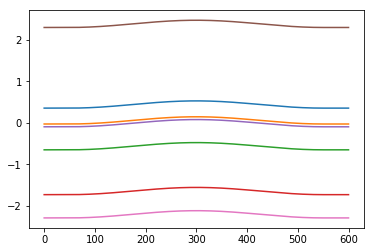

In [20]:
# Prepare path
Q0_panda = panda.get_qcur()

N_t = 500
N_rep = 1
MAG = 10#np.deg2rad(5)
e_POS = np.deg2rad([[MAG]*PANDA_DOF])*np.transpose([((np.sin(np.pi*(np.arange(N_t*N_rep+1)*2-N_t/2)/N_t)+1)/2)])
e_POS = Q0_panda+np.pad(e_POS, [[50,50],[0,0]],'edge')
plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [21]:
gtimer.reset()
panda.reset()
time.sleep(0.1)
qcount_panda_list = []
looptime_list = []
networktime_list = []
qcount = 0 
i_q = 0
while i_q <len(e_POS):
    Q = e_POS[i_q]
    gtimer.tic("loop")
    Q_panda = Q
    i_q += panda.move_possible_joints_x4(Q_panda)
    qcount = panda.qcount
    qcount_panda_list.append(panda.qcount)
    looptime_list.append(gtimer.toc("loop"))
panda.stop_tracking()

{'stop': True}

loop: 	11901.0 ms/2392 = 4.975 ms (1.142/14.464)



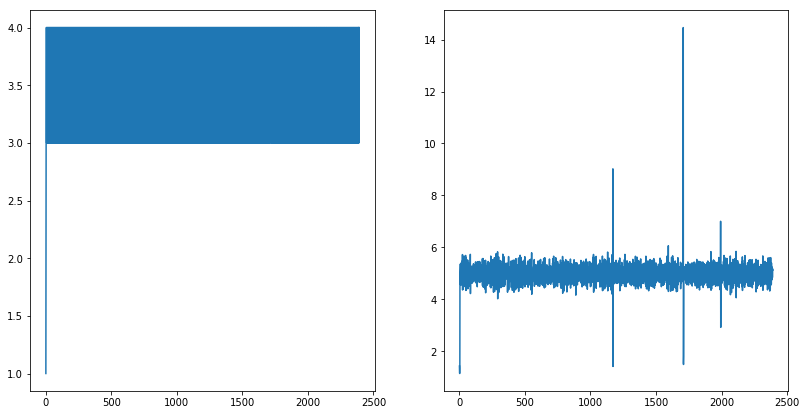

In [22]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_panda_list)
plt.subplot(1,3,2)
ax = plt.plot(looptime_list)
print(gtimer)

In [23]:
panda.reset()
Q0_panda = panda.get_qcur()
panda.move_joint_interpolated(qtar=Q0_panda+np.deg2rad(10), N_div=200)
panda.reset()
Q0_panda = panda.get_qcur()
panda.move_joint_interpolated(qtar=Q0_panda+np.deg2rad(-10), N_div=200)

# Test both

In [24]:
import matplotlib.pyplot as plt
import time
import numpy as np
from pkg.utils import *
import rospy
gtimer = GlobalTimer.instance()
rospy.init_node('indy_test', anonymous=True)

In [25]:
from pkg.indy_repeater import *
indy_ip = "192.168.0.63"  # Robot (Indy) IP
indy_name = "NRMK-Indy7"  # Robot name (Indy7)
indy = indytraj_client(server_ip=indy_ip, robot_name=indy_name)

In [26]:
indy.connect()
indy.set_collision_level(5)
indy.set_joint_vel_level(3)
indy.set_task_vel_level(3)
indy.set_joint_blend_radius(20)
indy.set_task_blend_radius(0.2)

print(indy.get_collision_level())
print(indy.get_joint_vel_level())
print(indy.get_task_vel_level())
print(indy.get_joint_blend_radius())
print(indy.get_task_blend_radius())


indy.stop_motion()

indy.disconnect()

Connect: Server IP (192.168.0.63)
5
3
3
20.0
0.2


In [27]:
from pkg.panda_repeater import *
PANDA_DOF = 7
panda = PandaRepeater()

In [28]:
Q0_panda = panda.get_qcur()

[ 0.         -0.         -0.          0.         -0.          0.
  0.35570307 -0.02772722 -0.65090143 -1.73284205 -0.09499131  2.30197711
 -2.29424663]
[ 0.         -0.         -0.          0.         -0.          0.
  0.35570307 -0.02772722 -0.65090143 -1.73284205 -0.09499131  2.30197711
 -2.29424663]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


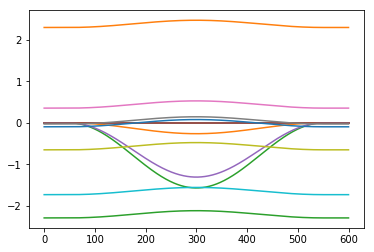

In [29]:
# Prepare path

N_t = 500
PORT_REPEATER = 1189
indy_idx = np.arange(6)
panda_idx = np.arange(7)+6

MAG_indy = 1#np.deg2rad(5)
MAG_panda = 10#np.deg2rad(5)
e_POS_indy = np.deg2rad([[0, -15, -90, 0, -75, 0]])*np.transpose([MAG_indy*((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS_indy = np.pad(e_POS_indy, [[50,50],[0,0]],'edge')
e_POS_panda = np.deg2rad([[MAG_panda]*PANDA_DOF])*np.transpose([((np.sin(np.pi*(np.arange(N_t+1)*2-N_t/2)/N_t)+1)/2)])
e_POS_panda = Q0_panda+np.pad(e_POS_panda, [[50,50],[0,0]],'edge')
e_POS = np.concatenate([e_POS_indy, e_POS_panda], axis=1)

plt.plot(e_POS)
print(e_POS[0])
print(e_POS[-1])
print(e_POS[0]-e_POS[-1])

In [32]:
gtimer.reset()
indy.joint_move_make_sure(e_POS[0], N_repeat=5, connect=True)
indy.init_online_tracking(e_POS[0])
panda.reset()

time.sleep(0.5)

qcount = 0
qcount_indy_list = []
qcount_panda_list = []
looptime_list = []
networktime_indy_list = []
networktime_panda_list = []
indy_sent = panda_sent = False
i_q = 0
while True:
    gtimer.tic("loop")
        
    if indy_sent and panda_sent:
        indy_sent = panda_sent = False        
        i_q += 1
        if i_q >= len(e_POS):
            break
    Q = e_POS[i_q]
    Q_indy = Q[indy_idx]#[0]*6
    Q_panda = Q[panda_idx]
    
    if not indy_sent:
        gtimer.tic("send_recv_indy")
        indy_sent = indy.move_possible_joints_x4(Q_indy)
        ntime_indy = gtimer.toc("send_recv_indy")
        networktime_indy_list.append(ntime_indy)
    else:
        indy.get_qcount()
        
    if not panda_sent:
        gtimer.tic("send_recv_panda")
        panda_sent = panda.move_possible_joints_x4(Q_panda)
        ntime_panda = gtimer.toc("send_recv_panda")
        networktime_panda_list.append(ntime_panda)
    else:
        panda.get_qcount()
    qcount_indy_list.append(indy.qcount)
    qcount_panda_list.append(panda.qcount)
    looptime_list.append(gtimer.toc("loop"))
    
indy.stop_online_tracking()
panda.stop_tracking()

Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)
Connect: Server IP (192.168.0.63)


{'stop': True}

loop: 	13003.0 ms/2379 = 5.466 ms (2.051/574.63)
send_recv_indy: 	2890.0 ms/1484 = 1.948 ms (0.799/570.683)
send_recv_panda: 	8355.0 ms/2379 = 3.512 ms (1.038/9.977)



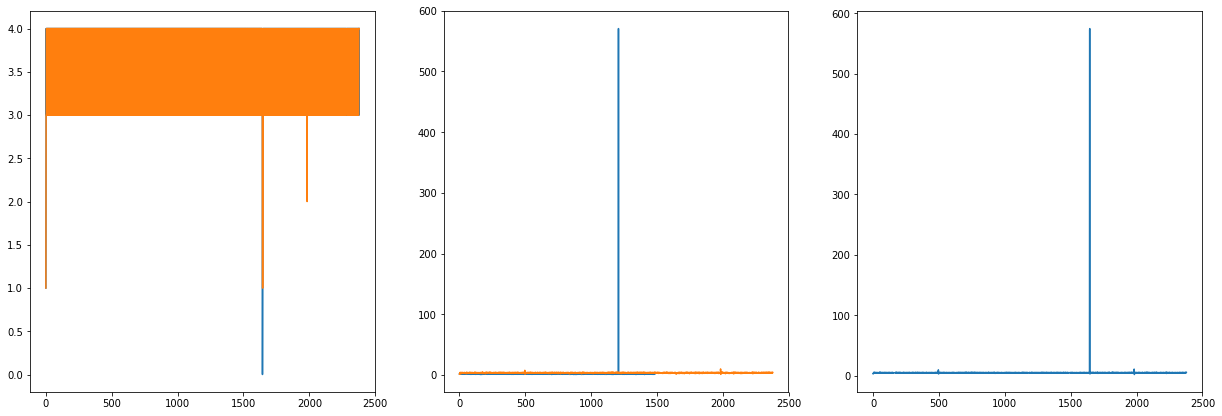

In [31]:
plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
ax = plt.plot(qcount_panda_list)
ax = plt.plot(qcount_indy_list)
plt.subplot(1,3,2)
ax = plt.plot(networktime_indy_list)
ax = plt.plot(networktime_panda_list)
plt.subplot(1,3,3)
ax = plt.plot(looptime_list)
print(gtimer)

# Inspect log data

In [21]:
dat = np.loadtxt("/home/junsu/Downloads/test.txt")
dat.shape

In [23]:
count_list = []
for i in range(len(dat)/10):
    count_list.append(np.sum(dat[:,0]==i))

[0, 10000, 70, 90]

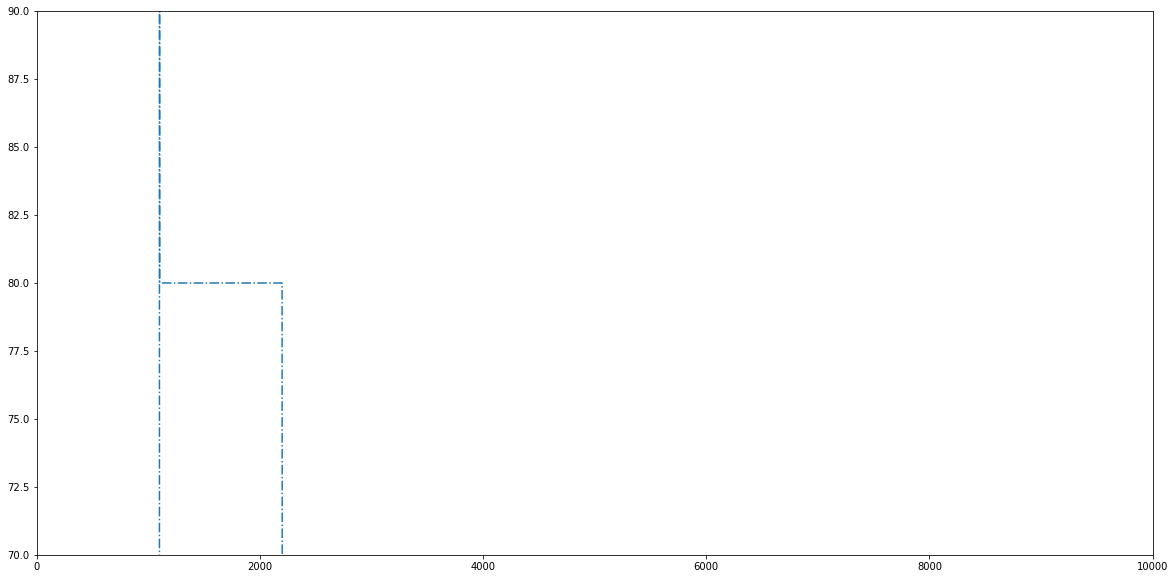

In [24]:
plt.figure(figsize=(20,10))
plt.plot(count_list,'-.')
plt.axis([0,10000,70,90])

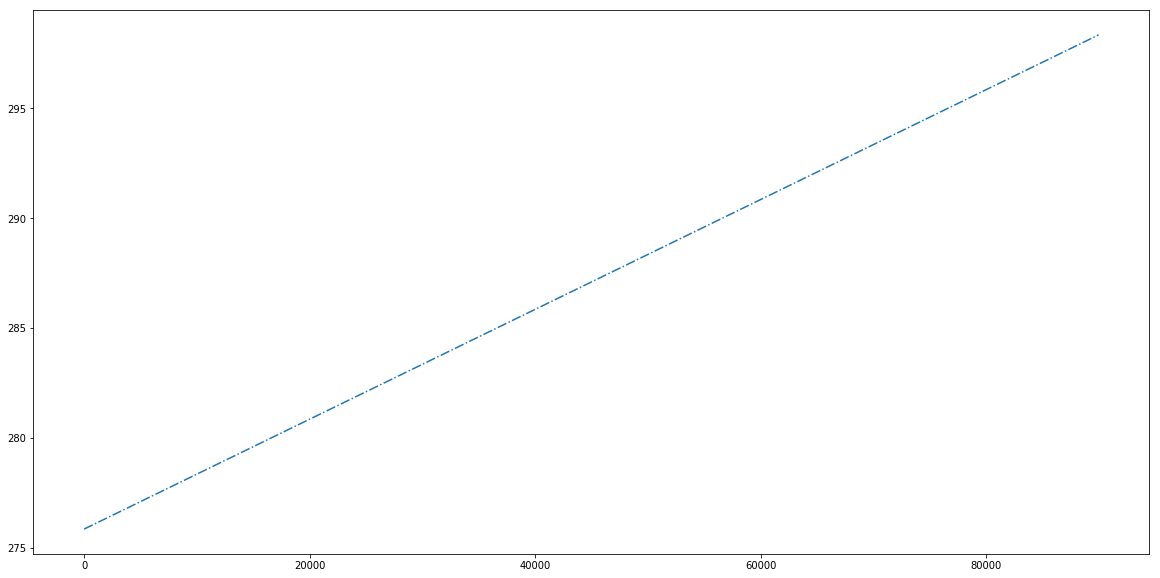

In [25]:
plt.figure(figsize=(20,10))
plt.plot(dat[:,1], '-.')
# plt.plot(dat[:,1]-dat[0,1]-np.arange(len(dat))*31,'-.')
# plt.axis([0,1200,0,50])

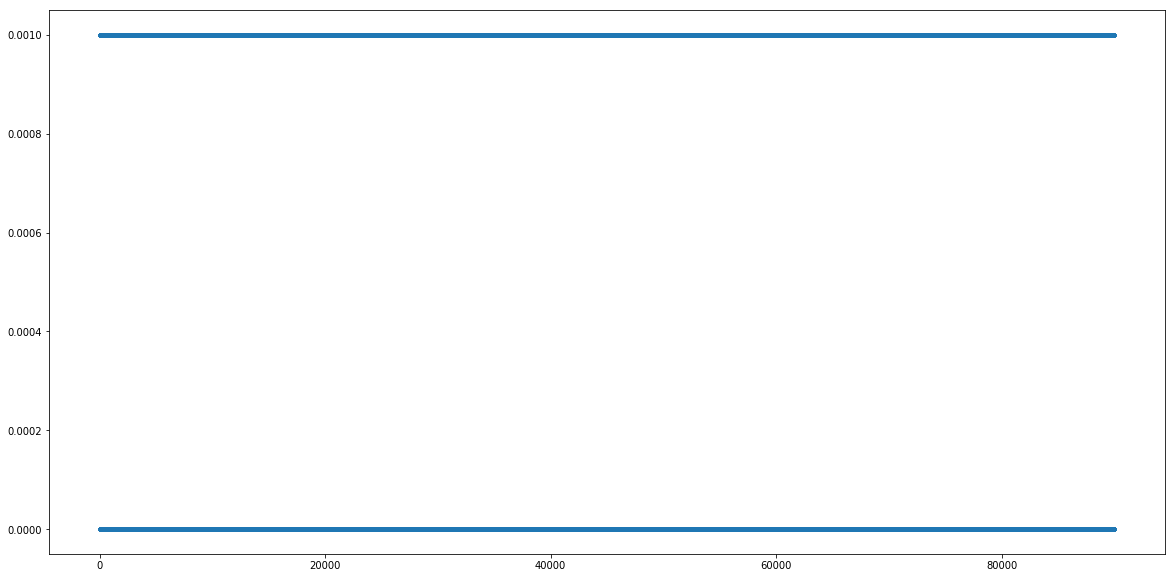

In [26]:
plt.figure(figsize=(20,10))
plt.plot(dat[1:,1]-dat[:-1,1], '.')
# plt.plot(dat[:,1]-dat[0,1]-np.arange(len(dat))*31,'-.')
# plt.axis([0,1200,0,50])

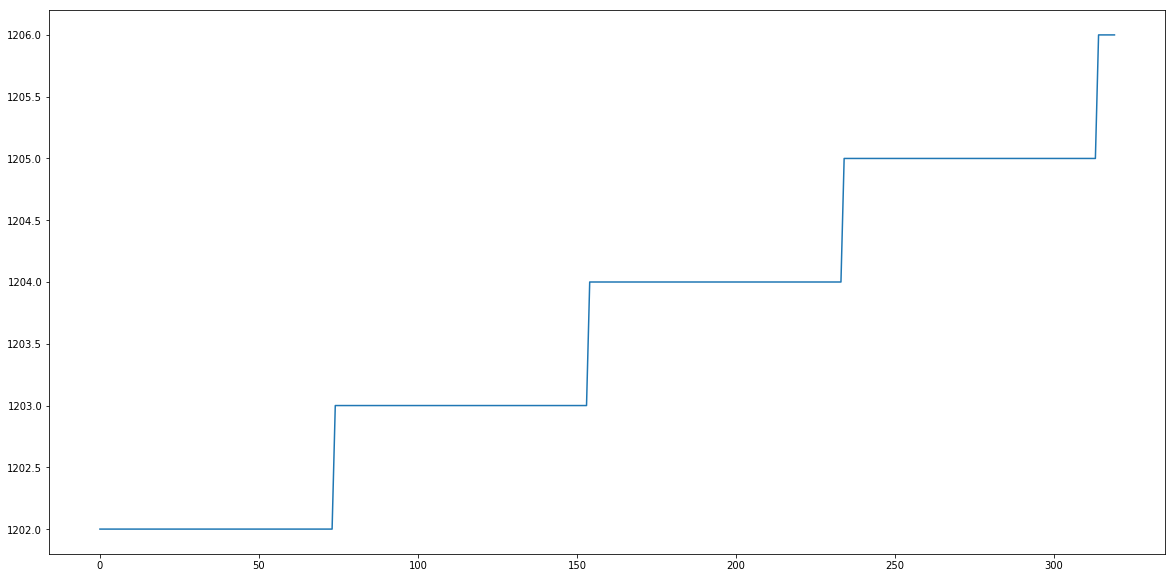

In [27]:
plt.figure(figsize=(20,10))
ax = plt.plot(dat[10000:10320,0])

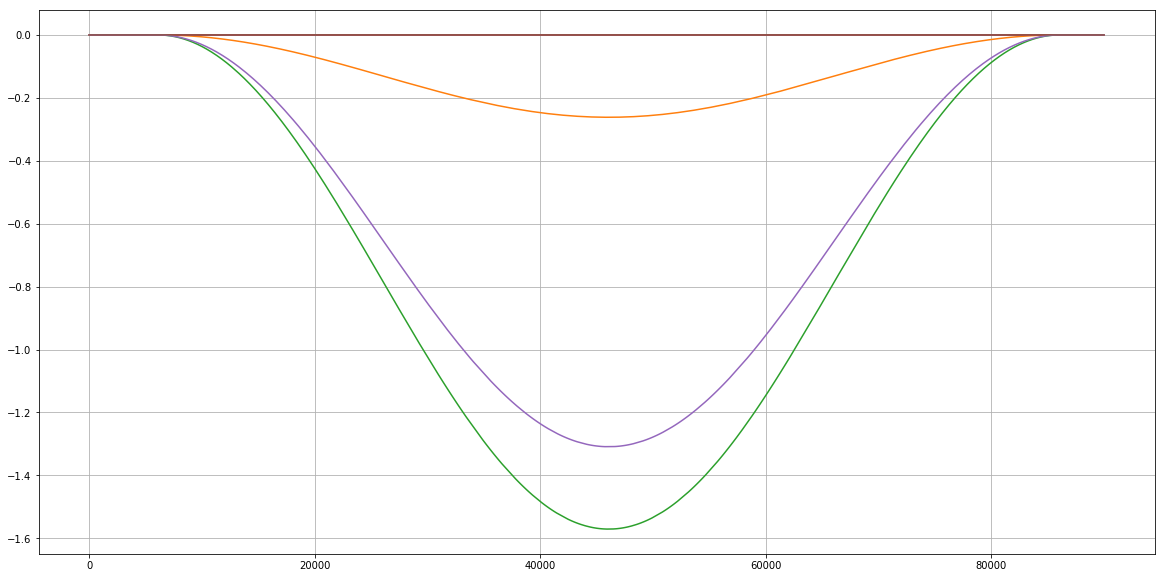

In [28]:
plt.figure(figsize=(20,10))
ax = plt.plot(dat[:,2:8])
plt.grid()

In [32]:
dx = differentiate(dat[:,2:8], 1/4e3)

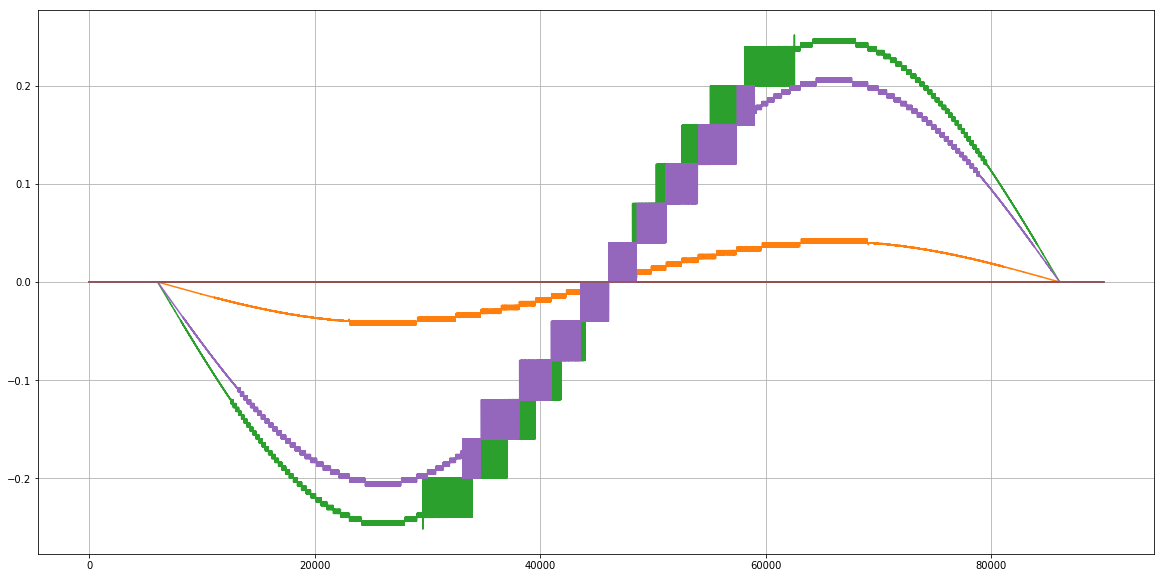

In [34]:
plt.figure(figsize=(20,10))
ax = plt.plot(dx)
plt.grid()

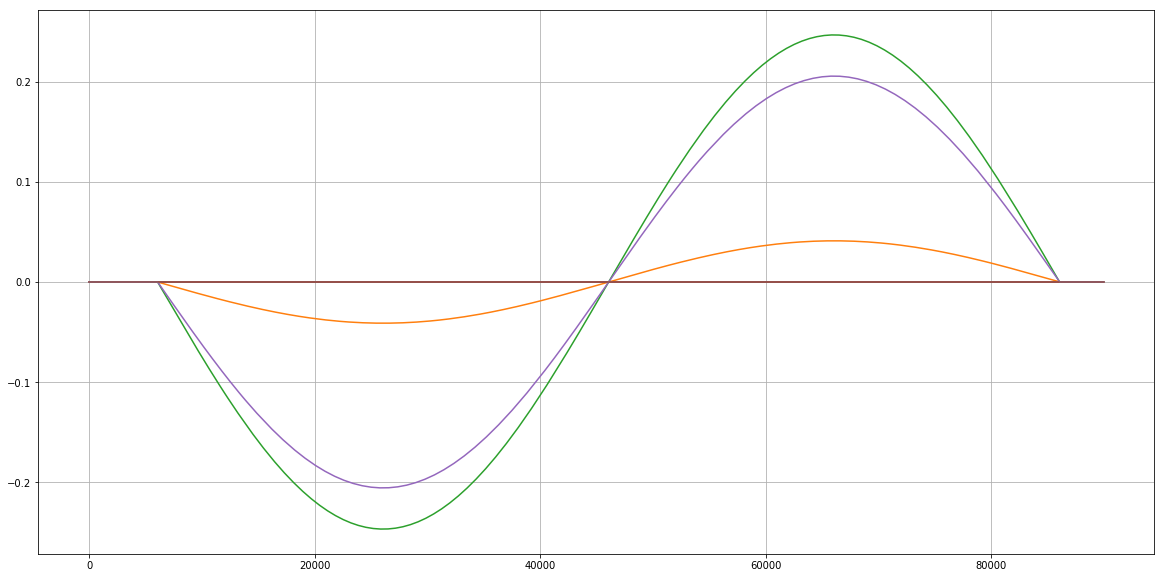

In [29]:
plt.figure(figsize=(20,10))
ax = plt.plot(dat[:,8:14])
plt.grid()

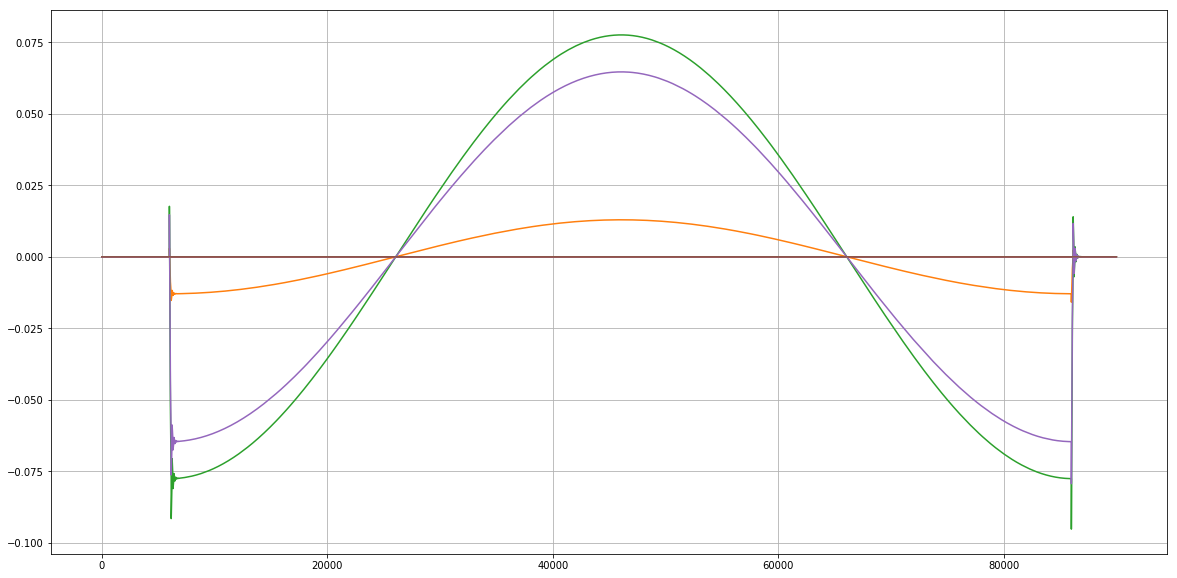

In [30]:
plt.figure(figsize=(20,10))
ax = plt.plot(dat[:,14:20])
plt.grid()